In [14]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import (
    adjusted_rand_score,
    normalized_mutual_info_score,
    homogeneity_score,
    completeness_score
)
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

In [15]:
import gdown
link="https://drive.google.com/drive/folders/1s2Ed1gkl-m6Dkn2CUp0xLxGUxLnbCa-U?dmr=1&ec=wgc-drive-globalnav-goto"
gdown.download_folder(link, output="/content/sample_data", quiet=False, use_cookies=False)

Retrieving folder contents


Processing file 1ss49tQXEitL0zcXfQ0M4_ZCvbuw31jK2 obesity_data_cleaned.csv
Processing file 158lb4W_q-OeN8_eldIDXXmz3bHtKTQDB obesity_data.csv
Processing file 1MIK9mmU09M93CRq1av__VKSdS_jDIaf1 obesity_famd_8D.csv
Processing file 1hSG1ZsrQJ_ys4Jn8h7OTTok_yzo0H1rD obesity_lda_4D.csv
Processing file 1oWxRqBMbBlqd3f5rDCTa_cwMNlxaCXWS obesity_regression_input.csv


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1ss49tQXEitL0zcXfQ0M4_ZCvbuw31jK2
To: /content/sample_data/obesity_data_cleaned.csv
100%|██████████| 1.47M/1.47M [00:00<00:00, 145MB/s]
Downloading...
From: https://drive.google.com/uc?id=158lb4W_q-OeN8_eldIDXXmz3bHtKTQDB
To: /content/sample_data/obesity_data.csv
100%|██████████| 2.73M/2.73M [00:00<00:00, 189MB/s]
Downloading...
From: https://drive.google.com/uc?id=1MIK9mmU09M93CRq1av__VKSdS_jDIaf1
To: /content/sample_data/obesity_famd_8D.csv
100%|██████████| 3.29M/3.29M [00:00<00:00, 116MB/s]
Downloading...
From: https://drive.google.com/uc?id=1hSG1ZsrQJ_ys4Jn8h7OTTok_yzo0H1rD
To: /content/sample_data/obesity_lda_4D.csv
100%|██████████| 1.68M/1.68M [00:00<00:00, 140MB/s]
Downloading...
From: https://drive.google.com/uc?id=1oWxRqBMbBlqd3f5rDCTa_cwMNlxaCXWS
To: /content/sample_data/obesity_regression_input.csv
100%|██████████| 4.57M

['/content/sample_data/obesity_data_cleaned.csv',
 '/content/sample_data/obesity_data.csv',
 '/content/sample_data/obesity_famd_8D.csv',
 '/content/sample_data/obesity_lda_4D.csv',
 '/content/sample_data/obesity_regression_input.csv']

# Hàm cho KMeans

In [16]:
def kmeans_init_centers(X, k):
    """
    Khởi tạo k tâm cụm ban đầu bằng cách chọn ngẫu nhiên k điểm từ dữ liệu
    """
    # Chọn ngẫu nhiên k hàng từ X làm tâm cụm ban đầu (không lặp lại)
    random_indices = np.random.choice(X.shape[0], k, replace=False)
    return X[random_indices]


def kmeans_assign_labels(X, centers):
    """
    Gán nhãn cụm cho mỗi điểm dữ liệu dựa trên khoảng cách đến các tâm cụm
    """
    # Tính ma trận khoảng cách giữa mọi điểm dữ liệu và mọi tâm cụm
    distances = cdist(X, centers)

    # Trả về index của tâm cụm có khoảng cách nhỏ nhất cho mỗi điểm
    labels = np.argmin(distances, axis=1)

    return labels


def kmeans_update_centers(X, labels, K):
    """
    Cập nhật vị trí tâm cụm bằng cách tính trung bình các điểm trong mỗi cụm
    """
    # Khởi tạo ma trận chứa tâm cụm mới
    new_centers = np.zeros((K, X.shape[1]))

    for k in range(K):
        # Lấy tất cả các điểm được gán vào cụm k
        points_in_cluster_k = X[labels == k, :]
        # Cập nhật tâm cụm k bằng trung bình các điểm trong cụm
        if len(points_in_cluster_k) > 0:
            new_centers[k, :] = np.mean(points_in_cluster_k, axis=0)

    return new_centers


def has_converged(centers, new_centers, tol=1e-10):
    """
    Kiểm tra xem thuật toán đã hội tụ chưa
    """
    # Hai tập tâm cụm giống nhau => thuật toán đã hội tụ
    centers_set = set([tuple(center) for center in centers])
    new_centers_set = set([tuple(center) for center in new_centers])

    return centers_set == new_centers_set


def kmeans(X, K, max_iter=1000):
    """
    Thuật toán K-Means clustering
    """
    # Bước 1: Khởi tạo K tâm cụm ngẫu nhiên
    initial_centers = kmeans_init_centers(X, K)
    centers = [initial_centers]

    # Danh sách lưu lịch sử nhãn qua các vòng lặp
    labels = []

    # Đếm số vòng lặp
    iteration = 0

    # Bước 2: Lặp cho đến khi hội tụ hoặc đạt max_iter
    while iteration < max_iter:
        # Gán nhãn cho mỗi điểm dựa trên tâm cụm hiện tại
        current_labels = kmeans_assign_labels(X, centers[-1])
        labels.append(current_labels)

        # Cập nhật tâm cụm dựa trên nhãn mới
        new_centers = kmeans_update_centers(X, current_labels, K)

        # Kiểm tra điều kiện hội tụ
        if has_converged(centers[-1], new_centers):
            print(f"Thuật toán hội tụ sau {iteration + 1} vòng lặp")
            break

        # Lưu tâm cụm mới vào lịch sử
        centers.append(new_centers)
        iteration += 1

    return centers, labels, iteration

# Áp dụng vào bài toán

## Với bộ dữ liệu gốc

In [17]:
df = pd.read_csv('/content/sample_data/obesity_data_cleaned.csv')
X = df.drop('NObeyesdad', axis=1)
y = df['NObeyesdad'].values

In [18]:
# Chuẩn hóa
scaler = StandardScaler()

numerical_cols = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])
X_scaled = X.values


### Áp dụng Kmeans với bộ dữ liệu gốc

In [19]:
np.random.seed(1)
y_unique = np.unique(y)
centers, labels, iterations = kmeans(X_scaled, K=len(y_unique), max_iter=100)

Thuật toán hội tụ sau 43 vòng lặp


### Đánh giá kết quả

In [20]:
# Lấy nhãn dự đoán cuối cùng từ KMeans
predicted_labels = labels[-1]

print("ĐÁNH GIÁ KẾT QUẢ CLUSTERING VỚI BỘ DỮ LIỆU GỐC")

ari = adjusted_rand_score(y, predicted_labels)
print(f"\n1. Adjusted Rand Index (ARI):          {ari:.4f}")

nmi = normalized_mutual_info_score(y, predicted_labels)
print(f"\n2. Normalized Mutual Information (NMI): {nmi:.4f}")

homogeneity = homogeneity_score(y, predicted_labels)
print(f"\n3. Homogeneity:                         {homogeneity:.4f}")

completeness = completeness_score(y, predicted_labels)
print(f"\n4. Completeness:                        {completeness:.4f}")



ĐÁNH GIÁ KẾT QUẢ CLUSTERING VỚI BỘ DỮ LIỆU GỐC

1. Adjusted Rand Index (ARI):          0.2616

2. Normalized Mutual Information (NMI): 0.3309

3. Homogeneity:                         0.3286

4. Completeness:                        0.3333


## Với dữ liệu được LDA về 4 chiều

In [21]:
# Load dữ liệu LDA 4 chiều từ file CSV
df_lda = pd.read_csv('/content/sample_data/obesity_lda_4D.csv')
X_lda = df_lda[['LD1', 'LD2', 'LD3', 'LD4']].values

### KMeans với LDA 4 chiều

In [22]:
np.random.seed(1)
centers_lda, labels_lda, iterations_lda = kmeans(X_lda, K=len(y_unique), max_iter=100)

Thuật toán hội tụ sau 55 vòng lặp


### Đánh giá định lượng với LDA 4 chiều

In [23]:
# Lấy nhãn dự đoán cuối cùng từ KMeans
predicted_labels = labels_lda[-1]

print("ĐÁNH GIÁ KẾT QUẢ CLUSTERING VỚI BỘ DỮ LIỆU LDA4D")

ari = adjusted_rand_score(y, predicted_labels)
print(f"\n1. Adjusted Rand Index (ARI):          {ari:.4f}")

nmi = normalized_mutual_info_score(y, predicted_labels)
print(f"\n2. Normalized Mutual Information (NMI): {nmi:.4f}")

homogeneity = homogeneity_score(y, predicted_labels)
print(f"\n3. Homogeneity:                         {homogeneity:.4f}")

completeness = completeness_score(y, predicted_labels)
print(f"\n4. Completeness:                        {completeness:.4f}")



ĐÁNH GIÁ KẾT QUẢ CLUSTERING VỚI BỘ DỮ LIỆU LDA4D

1. Adjusted Rand Index (ARI):          0.5970

2. Normalized Mutual Information (NMI): 0.6444

3. Homogeneity:                         0.6424

4. Completeness:                        0.6464


### Trực quan hóa bằng LD1 và LD2 với KMeans và Nhãn gốc

In [24]:
# Mapping cho nhãn
target_mapping = {
    0: 'Insufficient_Weight',
    1: 'Normal_Weight',
    2: 'Obesity_Type_I',
    3: 'Obesity_Type_II',
    4: 'Obesity_Type_III',
    5: 'Overweight_Level_I',
    6: 'Overweight_Level_II'
}

In [25]:
def visualize_clustering(X_lda, y_true, y_pred, centers, title="Trực quan hóa các cụm"):
    # Lấy 2 chiều đầu tiên của LDA
    X_2d = X_lda[:, :2]
    centers_2d = centers[:, :2] if centers.shape[1] > 2 else centers

    # Định nghĩa màu sắc
    colors_class = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0']
    colors_cluster = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

    fig, axes = plt.subplots(1, 2, figsize=(16, 7))


    ax1 = axes[0]
    unique_classes = np.unique(y_true)

    for i, class_label in enumerate(unique_classes):
        mask = y_true == class_label
        ax1.scatter(
            X_2d[mask, 0],
            X_2d[mask, 1],
            c=[colors_class[i % len(colors_class)]],
            marker='o',
            s=100,
            alpha=0.7,
            edgecolors='black',
            linewidths=0.5,
            label=f'{target_mapping[class_label]}',
            zorder=3
        )

    ax1.set_xlabel('LD1', fontsize=12, fontweight='bold')
    ax1.set_ylabel('LD2', fontsize=12, fontweight='bold')
    ax1.set_title('(a) Nhãn gốc (Ground Truth)', fontsize=14, fontweight='bold')
    ax1.legend(loc='best', fontsize=9, framealpha=0.9)
    ax1.grid(True, alpha=0.3, zorder=0)

    ax2 = axes[1]
    unique_clusters = np.unique(y_pred)

    for i, cluster_label in enumerate(unique_clusters):
        mask = y_pred == cluster_label
        ax2.scatter(
            X_2d[mask, 0],
            X_2d[mask, 1],
            c=[colors_cluster[i % len(colors_cluster)]],
            marker='o',
            s=100,
            alpha=0.6,
            edgecolors='black',
            linewidths=0.5,
            label=f'Cụm {cluster_label}',
            zorder=3
        )

    # Vẽ tâm cụm và vòng tròn bao quanh
    for i, cluster_label in enumerate(unique_clusters):
        mask = y_pred == cluster_label
        cluster_points = X_2d[mask]

        if len(cluster_points) > 0:
            center = centers_2d[cluster_label]

            # Tính bán kính (khoảng cách xa nhất từ tâm đến các điểm trong cụm)
            distances = np.sqrt(np.sum((cluster_points - center)**2, axis=1))
            radius = np.max(distances) if len(distances) > 0 else 0

            # Vẽ tâm cụm
            ax2.scatter(
                center[0], center[1],
                c='red',
                marker='X',
                s=200,
                edgecolors='black',
                linewidths=2,
                zorder=5
            )

            # Vẽ vòng tròn bao quanh
            circle = Circle(
                (center[0], center[1]),
                radius,
                fill=False,
                edgecolor=colors_cluster[i % len(colors_cluster)],
                linewidth=2.5,
                linestyle='--',
                alpha=0.9,
                zorder=6
            )
            ax2.add_patch(circle)

    ax2.set_xlabel('LD1', fontsize=12, fontweight='bold')
    ax2.set_ylabel('LD2', fontsize=12, fontweight='bold')
    ax2.set_title('(b) Cụm KMeans', fontsize=14, fontweight='bold')
    ax2.legend(loc='best', fontsize=9, framealpha=0.9)
    ax2.grid(True, alpha=0.3, zorder=0)

    # Tiêu đề chung
    fig.suptitle(title, fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()


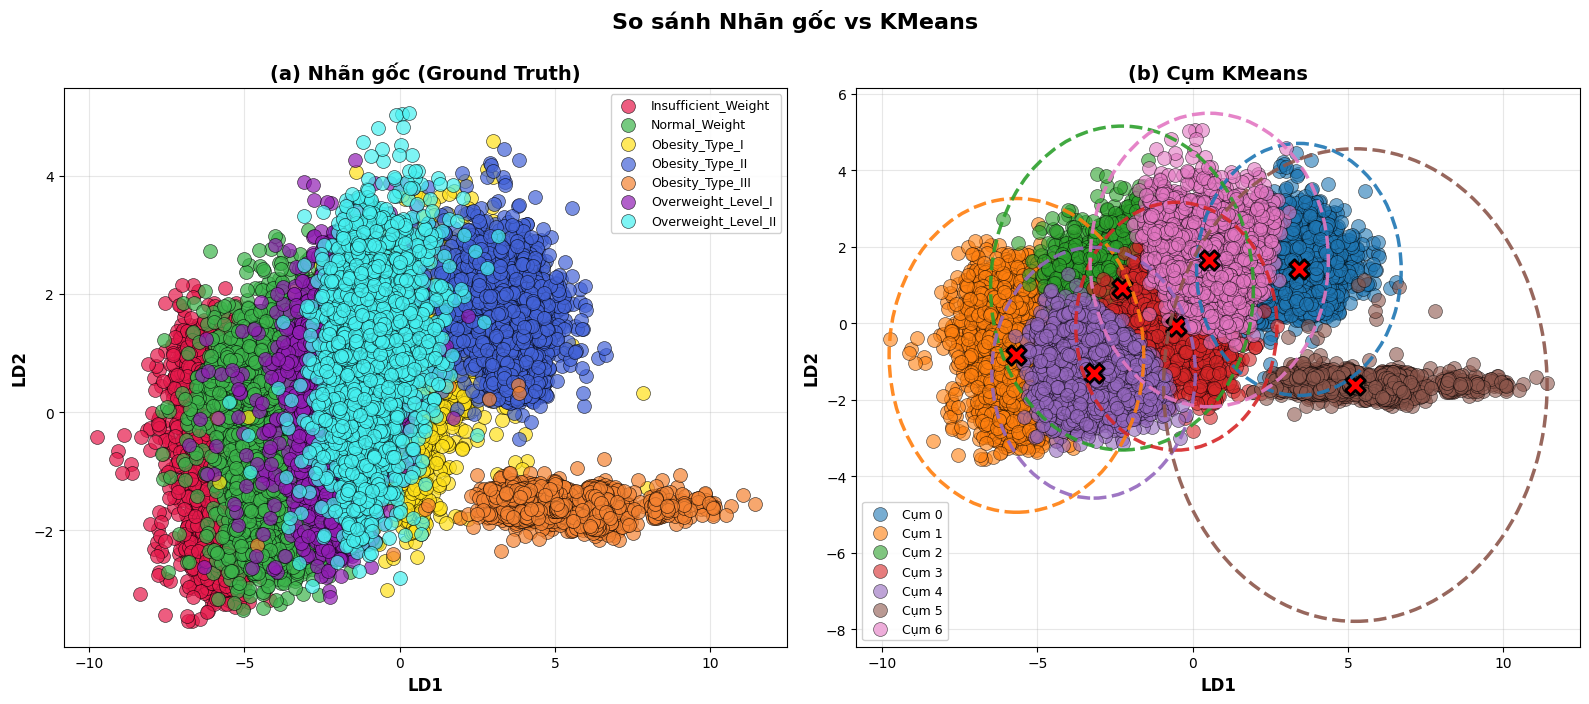

In [26]:
# Trực quan hóa riêng biệt với vòng tròn
visualize_clustering(
    X_lda,
    y,
    labels_lda[-1],
    centers_lda[-1],  # Tâm cụm cuối cùng
    title="So sánh Nhãn gốc vs KMeans"
)